<a href="https://colab.research.google.com/github/rakshitarajan/Basic-ML/blob/main/bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

In [2]:
X, y = make_classification(
    n_samples=600,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=3,
    class_sep=1.3,
    random_state=0
)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [3]:
def estimate_parameters(X, y):
    """Compute priors, class means, and covariances."""
    classes = np.unique(y)
    priors, means, covs = {}, {}, {}
    n = len(y)
    for c in classes:
        Xc = X[y == c]
        priors[c] = Xc.shape[0] / n
        means[c] = Xc.mean(axis=0)
        covs[c] = np.cov(Xc, rowvar=False)
    return classes, priors, means, covs

classes, priors, means, covs = estimate_parameters(X_train, y_train)

print("Estimated Parameters:")
for c in classes:
    print(f"Class {c}: Prior={priors[c]:.3f}, Mean={means[c]}, Covariance=\n{covs[c]}\n")


Estimated Parameters:
Class 0: Prior=0.331, Mean=[-1.3047942   1.29784591], Covariance=
[[0.38023157 0.22160411]
 [0.22160411 0.16371859]]

Class 1: Prior=0.331, Mean=[1.32739142 1.34108042], Covariance=
[[1.11334397 0.69382108]
 [0.69382108 1.26783814]]

Class 2: Prior=0.338, Mean=[ 1.40536307 -1.15833751], Covariance=
[[0.73499003 0.43953528]
 [0.43953528 0.57602841]]



In [4]:
def gaussian_pdf(x, mean, cov):
    """Multivariate Gaussian density p(x|mean, cov)."""
    d = mean.shape[0]
    cov += 1e-8 * np.eye(d)  # numerical stability
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1 / np.sqrt((2 * np.pi) ** d * det)
    diff = (x - mean)
    expo = -0.5 * np.sum(diff @ inv * diff, axis=1)
    return norm_const * np.exp(expo)

In [5]:
def predict_qda(X, classes, priors, means, covs):
    probs = np.zeros((X.shape[0], len(classes)))
    for i, c in enumerate(classes):
        like = gaussian_pdf(X, means[c], covs[c])
        probs[:, i] = priors[c] * like
    preds = classes[np.argmax(probs, axis=1)]
    return preds, probs

y_pred_qda, probs_qda = predict_qda(X_test, classes, priors, means, covs)
print("\n--- QDA Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_qda))
print(classification_report(y_test, y_pred_qda, zero_division=0))




--- QDA Results ---
Accuracy: 0.9611111111111111
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        59
           1       1.00      0.90      0.95        60
           2       0.95      0.98      0.97        61

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



In [6]:
def estimate_shared_cov(X, y):
    """Estimate shared covariance for all classes."""
    n, d = X.shape
    pooled_cov = np.zeros((d, d))
    classes = np.unique(y)
    for c in classes:
        Xc = X[y == c]
        nc = Xc.shape[0]
        pooled_cov += (nc - 1) * np.cov(Xc, rowvar=False)
    pooled_cov /= (n - len(classes))
    return pooled_cov

shared_cov = estimate_shared_cov(X_train, y_train)

def predict_lda(X, classes, priors, means, shared_cov):
    probs = np.zeros((X.shape[0], len(classes)))
    for i, c in enumerate(classes):
        like = gaussian_pdf(X, means[c], shared_cov)
        probs[:, i] = priors[c] * like
    preds = classes[np.argmax(probs, axis=1)]
    return preds, probs

y_pred_lda, probs_lda = predict_lda(X_test, classes, priors, means, shared_cov)
print("\n--- LDA Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda, zero_division=0))

# -------------------------------------------------
# STEP 6: Display confusion matrices
# -------------------------------------------------



--- LDA Results ---
Accuracy: 0.9222222222222223
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        59
           1       1.00      0.78      0.88        60
           2       0.94      0.98      0.96        61

    accuracy                           0.92       180
   macro avg       0.93      0.92      0.92       180
weighted avg       0.93      0.92      0.92       180



In [7]:
print("Confusion Matrix (QDA):\n", confusion_matrix(y_test, y_pred_qda))
print("\nConfusion Matrix (LDA):\n", confusion_matrix(y_test, y_pred_lda))


Confusion Matrix (QDA):
 [[59  0  0]
 [ 3 54  3]
 [ 1  0 60]]

Confusion Matrix (LDA):
 [[59  0  0]
 [ 9 47  4]
 [ 1  0 60]]


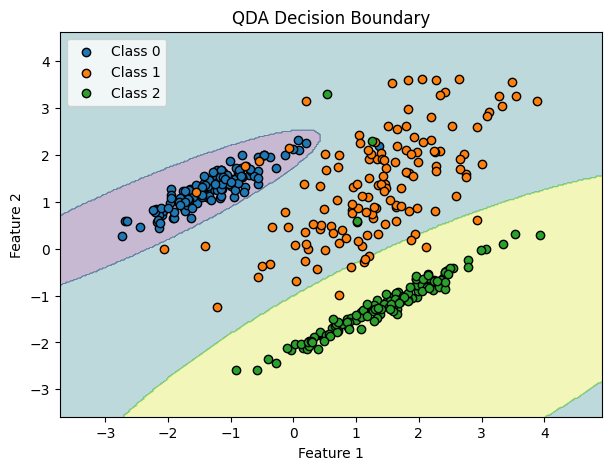

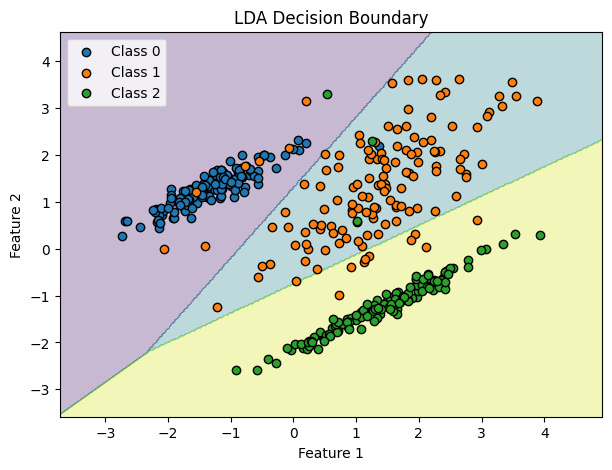

In [8]:
def plot_decision_boundary(predict_fn, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds, _ = predict_fn(grid)
    zz = preds.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, zz, alpha=0.3)
    for c in np.unique(y):
        plt.scatter(X[y == c, 0], X[y == c, 1], label=f"Class {c}", edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

plot_decision_boundary(lambda x: predict_qda(x, classes, priors, means, covs), X_train, y_train, "QDA Decision Boundary")
plot_decision_boundary(lambda x: predict_lda(x, classes, priors, means, shared_cov), X_train, y_train, "LDA Decision Boundary")


In [9]:
df = pd.DataFrame(X_test[:10], columns=["Feature1", "Feature2"])
df["True Class"] = y_test[:10]
df["Pred(QDA)"] = y_pred_qda[:10]
df["Pred(LDA)"] = y_pred_lda[:10]
print("\nSample Predictions:")
print(df)


Sample Predictions:
   Feature1  Feature2  True Class  Pred(QDA)  Pred(LDA)
0  1.040363 -1.375649           2          2          2
1  2.383328  1.323491           1          1          1
2  2.313249  1.283411           1          1          1
3  3.146127 -0.384320           2          2          2
4 -1.230084  1.172359           0          0          0
5 -1.380920  1.130005           0          0          0
6  2.171805  2.963713           1          1          1
7  0.580380  0.489018           1          1          1
8  1.360698  1.661824           1          1          1
9  2.271840  2.617683           1          1          1
